In [0]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip && unzip summer2winter-yosemite

--2019-09-08 19:35:45--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.179.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.179.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip’

summer2winter-yosem 100%[===================>] 127.58M  33.8MB/s    in 4.3s    

2019-09-08 19:35:55 (29.4 MB/s) - ‘summer2winter-yosemite.zip’ saved [133783376/133783376]

Archive:  summer2winter-yosemite.zip
   creating: summer2winter_yosemite/
  inflating: summer2winter_yosemite/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/summer2winter_yosemite/
  inflating: __MACOSX/summer2winter_yosemite/._.DS_Store  
   creating: summer2winter_yosemite/summer/
  inflating: summer2winter_yosemite/summer/.DS_Store  
   creating: __MACOSX/summer2winter_yosemite/sum

In [0]:
# The reqired imports
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

In [0]:
# The data loader function
def data_loader(image_type, image_dir='summer2winter_yosemite', image_size=128, batch_size=32):
    
    # This transforms our images into torch tensor
    transformer = transforms.Compose([transforms.Resize(size=(image_size)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                       std=[0.5, 0.5, 0.5])])
    # This create the path for the downloaded image
    train_data_path = os.path.join(image_dir, image_type)
    test_data_path = os.path.join(image_dir, 'test_{}'.format(image_type))

    # The reads in the images from folder
    train_data = datasets.ImageFolder(root=train_data_path, transform=transformer)
    test_data = datasets.ImageFolder(root=test_data_path, transform=transformer)
    
    # This creates an iterator over the images
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    return train_data_loader, test_data_loader

In [0]:
def show(img):
    """
    Args:
        img: this is the image grid
    
    This function takes our image grid and print them
    npimg = img.numpy() # This convert the image to numpy object 
    plt.figure(figsize=(10,10)) # This create an image with figure size 10
    plt.yticks([]) # Removes the tick marks on the x-axis
    plt.xticks([]) # Removes the tick marks on the y-axis
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest') # This displays the image
    """
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.yticks([])
    plt.xticks([])
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [0]:
# name to specific data loaders are assigned
winter_images_data, _ = data_loader('winter')
summer_images_data, _ = data_loader('summer')

In [0]:
# Get the iterator and the for for batch is gotten
winter_images, _ = next(iter(winter_images_data))
summer_images, _ = next(iter(summer_images_data))

In [0]:
winter_images.shape

torch.Size([32, 3, 128, 128])

In [0]:
# The takes in a batch of images and normalize the such that they have a mean of 
# 0.5 and standard deviation of 0.5
winter_image_grid = torchvision.utils.make_grid(winter_images, normalize=True)
summer_image_grid = torchvision.utils.make_grid(summer_images, normalize=True)

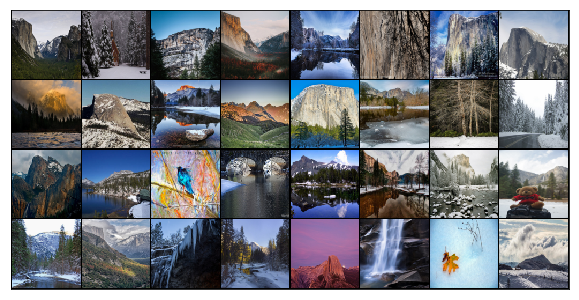

In [0]:
# Winter image are been displayed
show(winter_image_grid)

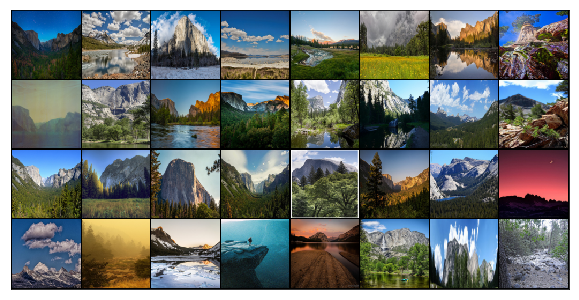

In [0]:
# Summer images are been displayed
show(summer_image_grid)

In [0]:
# The residual block class used in the encoder is defined here
class Residual_block(nn.Module):
    
    def __init__(self, num_of_channel):
        
        super(Residual_block, self).__init__()
        
        self.res_block = nn.Sequential(
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(num_of_channel, num_of_channel, kernel_size=3),
                        nn.InstanceNorm2d(num_of_channel),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(num_of_channel, num_of_channel, kernel_size=3),
                        nn.InstanceNorm2d(num_of_channel)
                        )
        
        
    def forward(self, x):
        
        initial_input = x
        final_output = self.res_block(x)
        
        return initial_input + final_output

In [0]:
# Encode decoder generator
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.first_conv_layer = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.second_conv_layer = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        
        self.six_residual_blocks = [Residual_block(num_of_channel=128) for _ in np.arange(6)]
        
        self.first_deconvolutional_layer = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.second_deconvolutional_layer = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        
        self.generator = nn.Sequential(
                         self.first_conv_layer,
                         nn.InstanceNorm2d(64),
                         nn.ReLU(inplace=True),
                         self.second_conv_layer,
                         nn.InstanceNorm2d(128),
                         nn.ReLU(inplace=True),
                         *self.six_residual_blocks,
                         self.first_deconvolutional_layer,
                         nn.InstanceNorm2d(64),
                         nn.ReLU(inplace=True),
                         self.second_deconvolutional_layer
                         )
       
    
    def forward(self, x):
        return torch.tanh(self.generator(x))
        

In [0]:
def conv_layer(input_channel, output_channel, paddings=1, instance_norm=True):
    
    layer = []
    
    if instance_norm:
        layer.append(nn.Conv2d(input_channel, output_channel, kernel_size=4, stride=2, padding=paddings))
        layer.append(nn.InstanceNorm2d(output_channel))
    
    else:
        layer.append(nn.Conv2d(input_channel, output_channel, kernel_size=4, stride=2, padding=paddings))
    
    return nn.Sequential(*layer)

In [0]:
# PatchGAN Discriminator 
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        self.patchGAN = nn.Sequential(
                            conv_layer(3, 64, instance_norm=False),
                            nn.LeakyReLU(0.2, inplace=True),
                            conv_layer(64, 128, instance_norm=True),
                            nn.LeakyReLU(0.2, inplace=True),
                            conv_layer(128, 256, instance_norm=True),
                            nn.LeakyReLU(0.2, inplace=True),
                            conv_layer(256, 512, instance_norm=True),
                            nn.LeakyReLU(0.2, inplace=True),
                            conv_layer(512, 1, instance_norm=False, paddings=0)
                            )
    def forward(self, x):
        x = self.patchGAN(x)
        return x

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cupu')

In [0]:
# Intializing our models 
generator_x_to_y = Generator()
generator_y_to_x = Generator()

discriminator_x = Discriminator()
discriminator_y = Discriminator()

print(generator_x_to_y.to(device))
print('\n\n=================================================================================================\n\n')
print(generator_y_to_x.to(device))
print('\n\n=================================================================================================\n\n')
print(discriminator_x.to(device))
print('\n\n=================================================================================================\n\n')
print(discriminator_y.to(device))

Generator(
  (first_conv_layer): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (second_conv_layer): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (first_deconvolutional_layer): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (second_deconvolutional_layer): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (generator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace)
    (6): Residual_block(
      (res_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): Instan

In [0]:
# Implementation of mean square loss (L2 loss)
discriminator_real_loss = lambda x: torch.mean((x-1)**2)
discriminator_fake_loss = lambda x: torch.mean((x)**2)
# Implementation of consistency loss
forward_consitency_loss = nn.L1Loss()
backward_consitency_loss = nn.L1Loss()
# Implementation of idfentity loss 
# Note identity loss is usually considered in the case of color restoration
identity_loss = nn.L1Loss()

In [0]:
import itertools

In [0]:
# Optimizers
learning_rate = 0.0002
beta1 = 0.5
beta2 =0.999


disciminator_y_optimizer = torch.optim.Adam(discriminator_y.parameters(), 
                                           lr=learning_rate, betas=[beta1, beta2])

disciminator_x_optimizer = torch.optim.Adam(discriminator_x.parameters(), 
                                            lr=learning_rate, betas=[beta1, beta2])

generator_optimizer = torch.optim.Adam(itertools.chain(generator_x_to_y.parameters(),
                                                       generator_y_to_x.parameters()), 
                                                       lr=learning_rate, betas=[beta1, beta2])

In [0]:
lambda_x = 10
lambda_y = 10
lambda_idt = 0.5

x_data, x_test_data = data_loader('winter')
y_data, y_test_data = data_loader('summer')

x_iter = iter(x_data)
y_iter = iter(y_data)

len_of_batches = min(len(x_iter), len(y_iter))

# The loss are store into this arrys for ploting
discriminator_y_array = []
discriminator_x_array = []
generator_array = []

number = 1000
num_epoch = number * len_of_batches

for epoch in range(1, num_epoch):

    # This reloads the iterator 
    if epoch % len_of_batches == 0:
        x_iter = iter(x_data)
        y_iter = iter(y_data)
        
    x_images, _ = next(x_iter)
    y_images, _ = next(y_iter)
     
    x_images = x_images.to(device)
    y_images = y_images.to(device)
    
    ##############################################   
    #    Discriminator y training implemention   #
    #    disciminator_y                          #
    ##############################################
    # Fake_y image
    # generate fake images of y using x_images and also compute fake_y_loss
    disciminator_y_optimizer.zero_grad()
    fake_y = generator_x_to_y(x_images)
    # The fake_y images are passed to the discriminator_y
    logit_y_fake = discriminator_y(fake_y)
    # The discriminator fake loss is computed with the fake_y image
    loss_fake_y = discriminator_fake_loss(logit_y_fake)
    # Real_y image
    # The real y_images is passed to discriminator_y
    logit_y_real = discriminator_y(y_images)
    # The discriminator real loss is computed with the real y_images
    loss_real_y = discriminator_real_loss(logit_y_real)
    # Total discriminator_y loss
    total_loss_y = (loss_real_y + loss_fake_y)/2
    total_loss_y.backward(retain_graph=True)
    disciminator_y_optimizer.step()
    
    ###############################################   
    #    Discriminator x training implemention    #
    #    disciminator_x                           #
    ###############################################
    # Fake_x image
    # generate fake images of x using y_images and also compute fake_x_loss
    disciminator_x_optimizer.zero_grad()
    fake_x = generator_y_to_x(y_images)
    # The fake_x images are passed to the discriminator_x
    logit_x_fake = discriminator_x(fake_x)
    # The discriminator fake loss is computed with the fake_x image
    loss_fake_x = discriminator_fake_loss(logit_x_fake)
    # Real_x image
    # The real x_images is passed to discriminator_x
    logit_x_real = discriminator_x(x_images)
    # The discriminator real loss is computed with the real x_images
    loss_real_x = discriminator_real_loss(logit_x_real)
    # Total discriminator_y loss
    total_loss_x = (loss_real_x + loss_fake_x)/2
    total_loss_x.backward(retain_graph=True)
    disciminator_x_optimizer.step()
    
    
    
    ################################################   
    #    generator training implemention           #
    ################################################
    
    # The generator_x_to_y
    generator_optimizer.zero_grad()
    # we generate gen_fake_y from generator_x_to_y() using x_images
    gen_fake_y = generator_x_to_y(x_images)
    # The discriminator_y is given gen_fake_y
    dis_logit_y = discriminator_y(gen_fake_y)
    # The real discriminator_real_loss is computed with dis_logit_y
    gen_loss_x_to_y = discriminator_real_loss(dis_logit_y)
    
    # we try to rebuild x_images back with generator_y_to_x and gen_fake_y
    rebuilt_x_img = generator_y_to_x(gen_fake_y)
    # Forward cycle consistency loss
    forward_cycle_loss = forward_consitency_loss(x_images, rebuilt_x_img)*lambda_x
    
    # generator_y_to_x
    # we generate gen_fake_x from generator_y_to_x() using y_images 
    gen_fake_x = generator_y_to_x(y_images)
    # The discriminator_x is given gen_fake_x
    dis_logit_x = discriminator_x(gen_fake_x)
    # The real discriminator_real_loss is computed with dis_logit_x
    gen_loss_y_to_x = discriminator_real_loss(dis_logit_x)
    
    # we try to rebuild y_images back with generator_x_to_y and gen_fake_x
    rebuilt_y_img = generator_x_to_y(gen_fake_x)
    # Backward cycle consistency loss
    backward_cycle_loss = backward_consitency_loss(y_images, rebuilt_y_img)*lambda_y
    
    #Identity_loss
    idt_loss = ((identity_loss(generator_y_to_x(x_images), x_images)*lambda_x) +
                (identity_loss(generator_x_to_y(y_images), y_images)*lambda_y))*lambda_idt
    
    #Total Generator loss loss
    total_loss = idt_loss + backward_cycle_loss + forward_cycle_loss + gen_loss_y_to_x + gen_loss_x_to_y
    total_loss.backward()
    generator_optimizer.step()
    
    if epoch % len_of_batches == 30:
        print(f'[{int(epoch/len_of_batches)}/{num_epoch}] Discriminator_y loss: {round(total_loss_y.item(), 5)} | \
        Discriminator_x loss {round(total_loss_x.item(), 5)} |\
        Generator loss: {round(total_loss.item(), 5)}')
        discriminator_y_array.append(total_loss_y)
        discriminator_x_array.append(total_loss_x)
        generator_array.append(total_loss)

[1/31000] Discriminator_y loss: 0.18417 |         Discriminator_x loss 0.27633 |        Generator loss: 9.07661


KeyboardInterrupt: ignored

In [0]:
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# import torch
# import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    scipy.misc.imsave(path, merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    scipy.misc.imsave(path, merged)
    print('Saved {}'.format(path))


In [0]:
xx = torch.randn(3, 5)

In [0]:
test = torch.randn(1, 3, 128,128)
Discriminator()(test).shape

In [0]:
test = torch.randn(1, 3, 128, 128)
Generator()(test).shape